In [1]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pencil as pc
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid as trap
from astropy.convolution import convolve, Box1DKernel
import modes
from IPython.display import display, Latex

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


In [2]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True

In [3]:
sim = pc.get_sim(quiet=True)
ts = pc.read.ts()
yaver = pc.read.aver(plane_list='y')
xyaver = pc.read.aver(plane_list=['xy'])

Read 37645 lines.


In [4]:
class Phase(modes.Modes):
    """
    To analyze different phases
    """

    def __init__(self, path, t1, t2, z_ref, norm, sim, ts, xyaver, yaver, ini=False, dyn=True):
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=True)

        self.path = path
        self.t = self.yaver.t
        self.z_ref = z_ref
        self.norm = norm

        self.kf = super().get_kf()
        self.indx_t1 = np.argmin(np.abs(self.yaver.t-t1))
        self.indx_t2 = np.argmin(np.abs(self.yaver.t-t2))

        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_fourier = super().FT(self.uz_real, self.norm)
        # self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()
        self.upto_indx = super().upto(self.indx_t1, self.indx_t2)

    def indx_k(self, k_xtil:np.ndarray):
        indx = np.argmin(np.abs(self.k_til-k_xtil))
        return indx
    
    def Power(self, indx:int):
        P = np.exp(self.log_P[:self.upto_indx,indx])
        return P
    
    def Power_filtered(self, power:np.ndarray, sigma):
        P_filt = gaussian_filter(power[:self.upto_indx],sigma)
        return P_filt
    
    def f_freq(self, k_tilx):
        # freq = round(self.fmodes(k_tilx),3)
        freq = self.fmodes(k_tilx)
        return freq
    
    def p_freq(self, k_tilx, num):
        if isinstance(num, int):
            freq = round(self.pmodes(k_tilx,num),3)
        if isinstance(num, list):
            freq=[]
            for i in range(len(num)):
                freq.append(self.pmodes(k_tilx,i))
        return freq
    
    def plot(self, ax, P:np.ndarray, **kwargs):
        ax.plot(self.om_til[:self.upto_indx], P, **kwargs)
        # ax.grid()
        # ax.set_ylim(0,)
        ax.legend()

    def xlim(self, x_data:np.ndarray):
        min = x_data[0]
        max = x_data[-1]
        return (min,max)
    
    def cs_du(self, k_tilx):
        csd = self.cs_d*k_tilx/(self.L0*self.omega0)
        csu = self.cs_u*k_tilx/(self.L0*self.omega0)
        return (csd, csu)
    
    def mode_mass(self, x_data, y_data, u_d, **kwargs):
        """
        Calculate mode mass by integrating
        y_data in the interval x_data
        x_data: \omega_tilde range for a mode
        y_data: corresponding P(\omega_tilde)
        u_d: rms velocity in lower layer
        """
        # if kinematic == True:
        #     u_d = 0.1244
        # elif saturated == True:
        #     u_d = 0.0988
        # else:
        #     u_d = 1     #NOTE: not normalized
        norm = u_d/(3*self.kf)
        mass = trap(y_data, x=x_data)
        norm_mass = mass/norm
        return np.round(norm_mass, 4)

    def shift(self, f_om_calc, f_om):
        """
        Calculate relative freq shift from
        calculated \omega_f and theoretical
        \omega_f
        """
        return np.round((f_om_calc**2-f_om**2)/f_om**2, 4)

    def indx_fwhm(self, P_om, om_f, peak_f):
        """
        P_om: fitted spectrum (i.e., P(\omega)
        of P(\omega) vs \omega )
        om_f: freq range around \omega_f
        peak_f: freq of f mode calculated
        from fitting
        """
        indx_peak = np.argmin(np.abs(om_f-peak_f))
        peak = P_om[indx_peak]
        lh = np.argmin(np.abs(P_om[:indx_peak]-peak/2))
        uh = indx_peak + np.argmin(np.abs(P_om[indx_peak+1:]-peak/2))
        return [lh, uh]
    
    def line_width(self, om_f, indx_fwhm, f_om):
        return np.round((om_f[indx_fwhm[1]] - om_f[indx_fwhm[0]])/f_om, 4)

    def mode_fit_para(self, func, x_data, y_data, **kwargs):
        para, _ = curve_fit(func, x_data, y_data, **kwargs)
        return para
    
    def mode_fit_extend(self, func, x, para):
        y = func(x, *para)-x*para[4]-para[3]
        return y

    pass

In [5]:
path = './plots/'

In [6]:
kinematic = Phase(path, 250, 2000, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
saturated = Phase(path, 2905, 4305, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)

In [7]:
indx_kin = []
indx_sat = []

for i in [2,3,4]:
    indx_kin.append(kinematic.indx_k(i))
    indx_sat.append(saturated.indx_k(i))

In [8]:
kinematic.k_til[indx_kin]

array([2.36561927, 3.15415902, 3.94269878])

In [9]:
P_kin = kinematic.Power(indx_kin).T
P_sat = saturated.Power(indx_sat).T
# P_kin_filt = kinematic.Power_filtered(P_kin,3)
# P_sat_filt = saturated.Power_filtered(P_sat,3)

In [10]:
np.shape(P_kin)

(3, 2188)

In [11]:
# P_kin_filt

In [12]:
np.shape(P_kin)

(3, 2188)

In [13]:
P_kin_filt = np.empty(np.shape(P_kin))
for i in range(len(indx_kin)):
    P_kin_filt[i,:] =convolve(P_kin[i,:], Box1DKernel(5))


In [14]:
np.shape(P_kin_filt)

(3, 2188)

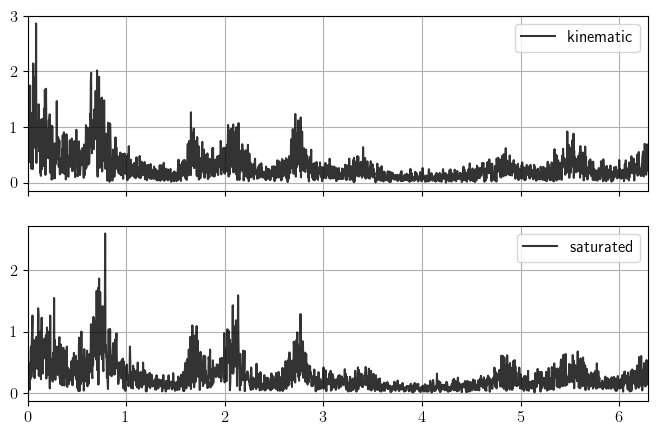

In [15]:
# fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,

# kinematic.plot(axs[0], P_kin, c='k', alpha=0.4, label='kinematic')

kinematic.plot(axs[0], P_kin[2], label='kinematic', c='k', alpha=0.8)
# kinematic.plot(axs[0], P_kin_filt[3], label='filtered')
saturated.plot(axs[1], P_sat[2], label='saturated', c='k', alpha=0.8)
# saturated.plot(axs[1], P_sat_filt[3], label='filtered')

# axs[1].set_xlim(0,kinematic.om_til[kinematic.upto_indx-1])
axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
# axs[1].set_ylim(0,1.75)
axs[0].grid()
axs[1].grid()

In [16]:
f_om = kinematic.f_freq(kinematic.k_til[indx_kin])
f_om

array([1.538, 1.776, 1.986])

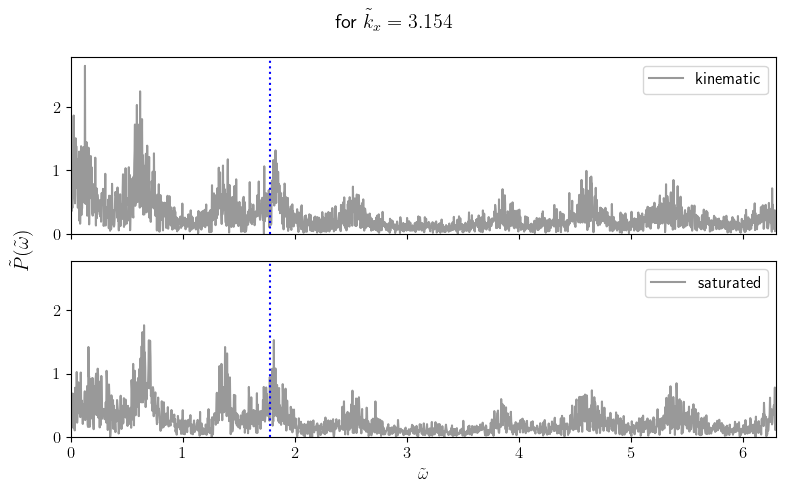

In [17]:
indx = 1
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))#sharex=True,

kinematic.plot(axs[0], P_kin[indx], c='k', alpha=0.4, label='kinematic')
# kinematic.plot(axs[0], P_kin_filt[indx], c='C1', label='filtered')
axs[0].axvline(x=f_om[indx], ls=':', c='b')

axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
axs[0].set_ylim(0,)
axs[0].legend()

saturated.plot(axs[1], P_sat[indx], c='k', alpha=0.4, label='saturated')
# # saturated.plot(axs[1], P_sat_filt[indx], c='C1', label='filtered')
axs[1].axvline(x=f_om[indx], ls=':', c='b')

# axs[1].set_ylim(0,)
# axs[1].legend()

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(fr"for $\tilde{{k}}_x={round(kinematic.k_til[indx_kin][indx], 3)}$")
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [18]:
om_kin = kinematic.om_til[:kinematic.upto_indx]
# indx_f = np.argmin(np.abs(om_kin-f_om))
idl_f_kin = []
idu_f_kin = []
P_f_kin = []
om_f_kin = []

d = [1.12, 1.5, 1.7]
u = [2.10, 2.2, 2.5]

for i in range(3):
    idl_f_kin.append(np.argmin(np.abs(om_kin - d[i])))
    idu_f_kin.append(np.argmin(np.abs(om_kin - u[i])))

    # P_f_kin.append(P_kin[i, idl_f_kin[i]:idu_f_kin[i]])
    P_f_kin.append(P_kin_filt[i, idl_f_kin[i]:idu_f_kin[i]])
    om_f_kin.append(om_kin[idl_f_kin[i]:idu_f_kin[i]])

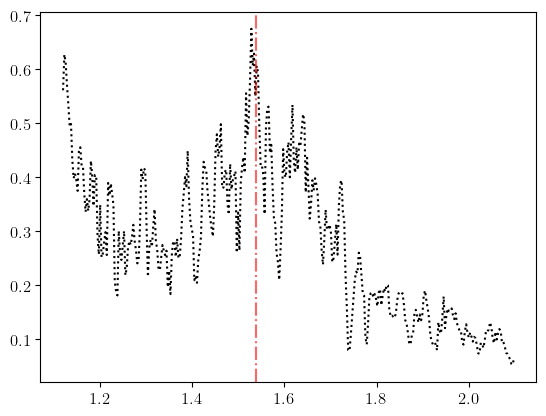

In [19]:
i = 0
plt.plot(om_f_kin[i], P_f_kin[i], c='k', ls=':')
plt.axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)

In [20]:
len(om_f_kin[0])

341

In [21]:
np.shape(P_kin)

(3, 2188)

In [22]:
# np.shape(P_f_kin)
len(P_f_kin[0])

341

In [23]:
om_sat = saturated.om_til[:saturated.upto_indx]
# indx_f = np.argmin(np.abs(om_sat-f_om))
idl_f_sat = []
idu_f_sat = []
P_f_sat = []
om_f_sat = []

d = [0.71, 0.9, 1.6]
u = [1.24, 2.2, 2.8]

for i in range(3):
    idl_f_sat.append(np.argmin(np.abs(om_sat - d[i])))
    idu_f_sat.append(np.argmin(np.abs(om_sat - u[i])))

    P_f_sat.append(P_sat[i, idl_f_sat[i]:idu_f_sat[i]])
    om_f_sat.append(om_sat[idl_f_sat[i]:idu_f_sat[i]])

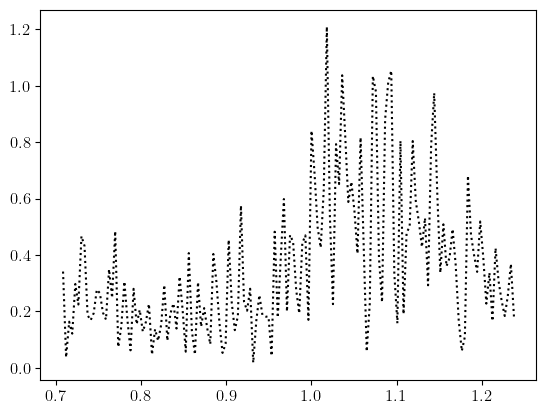

In [24]:
plt.plot(om_f_sat[0], P_f_sat[0], c='k', ls=':')

In [25]:
def lorentzian(x, a, b, c, d, e):
    y = a/((x-b)**2+np.exp(c))+d+e*x
    return y

In [26]:
1.535, 1.772, 1.982

(1.535, 1.772, 1.982)

In [27]:
f_kin = []
f_sat = []
para_f_kin = np.zeros((3,5))

a_kin = [0.6, 0.4, 0.4]
b_kin = [1.6, 1.7, 2.1]
d_kin = [-7.7, -1.0, -1.0]
e_kin = [0.4, 0.1, 0.1]

a_sat = [0.6, 0.4, 0.4]
b_sat = [1.6, 1.8, 2.2]
d_sat = [-7.7, -1.0, -1.0]
e_sat = [0.4, 0.1, 0.1]


x_kin = np.zeros((3,2000))
y_kin = np.zeros((3,2000))

for i in range(3):
    f_kin.append(kinematic.mode_fit(lorentzian, om_f_kin[i], P_f_kin[i], p0 = np.array([a_kin[i],b_kin[i],-2,d_kin[i],e_kin[i]]), base=False))#, sigma=sig_kin_f,base=False)
    f_sat.append(saturated.mode_fit(lorentzian, om_f_sat[i], P_f_sat[i], p0 = np.array([a_sat[i],b_sat[i],-2,d_sat[i],e_sat[i]]), base=False))#, sigma=sig_sat_f,base=False)
    para_f_kin[i,:] = kinematic.mode_fit_para(lorentzian, om_f_kin[i], P_f_kin[i], p0 = np.array([a_kin[i],b_kin[i],-2,d_kin[i],e_kin[i]]))
    x_kin[i] = np.linspace(para_f_kin[i,1]-1.0, para_f_kin[i,1]+1.0, 2000)
    y_kin[i] = kinematic.mode_fit_extend(lorentzian, x_kin[i], para_f_kin[i])


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

In [ ]:
para_f_kin[0,1]

1.5712949257831121

In [ ]:
para_f_kin

array([[ 3.07287964e-03,  1.57129493e+00, -4.41982770e+00,
         6.69904206e-01, -2.92593646e-01],
       [ 1.52277220e-03,  1.82875277e+00, -6.01589054e+00,
         6.29712133e-01, -2.25861973e-01],
       [ 1.44939227e-03,  2.07753078e+00, -5.51289526e+00,
         7.98647413e-01, -2.66081306e-01]])

In [ ]:
# len(f_kin[1])

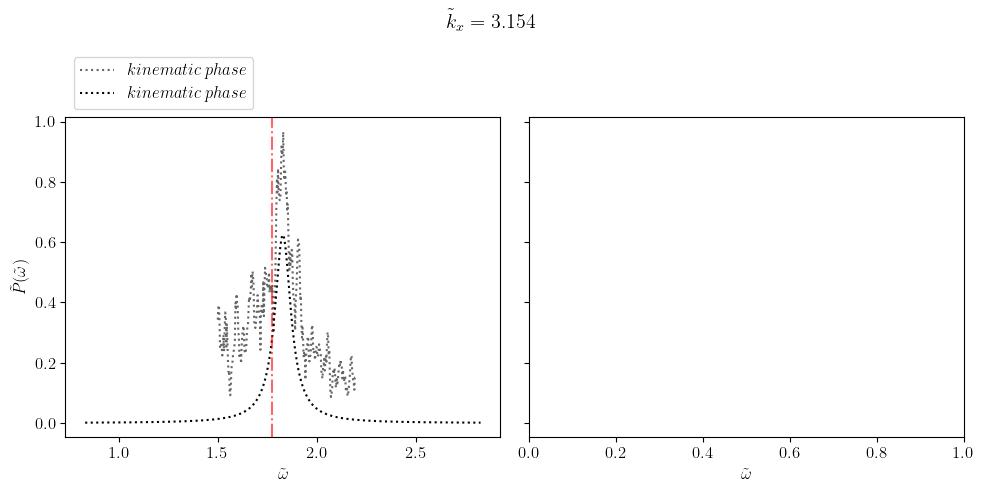

In [ ]:
i = 1
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))

axes[0].plot(om_f_kin[i], P_f_kin[i], color='k', ls=":", alpha=0.6, label=r'$kinematic$ $phase$')
# axes[0].plot(om_f_kin, f_kin, color='k')
# axes[0].plot(f_kin[i][0], f_kin[i][1], color='k')
axes[0].plot(x_kin[i], y_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
axes[0].axvline(x=f_om[i], ls='-.', c='r', alpha=0.6)
axes[0].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

axes[1].plot(om_f_sat[i], P_f_sat[i], color='k', ls=":", alpha=0.6, label=r'$saturated$ $phase$')
# # axes[1].plot(om_f_sat, f_sat, color='k')
# axes[1].plot(f_sat[i][0], f_sat[i][1], color='k')
axes[1].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

axes[0].set_xlabel(r"$\tilde{\omega}$")
axes[1].set_xlabel(r"$\tilde{\omega}$")
axes[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(fr"$\tilde{{k}}_x={round(kinematic.k_til[indx_kin][indx], 3)}$")
plt.tight_layout()
plt.show()

In [ ]:
# para_f_kin = 

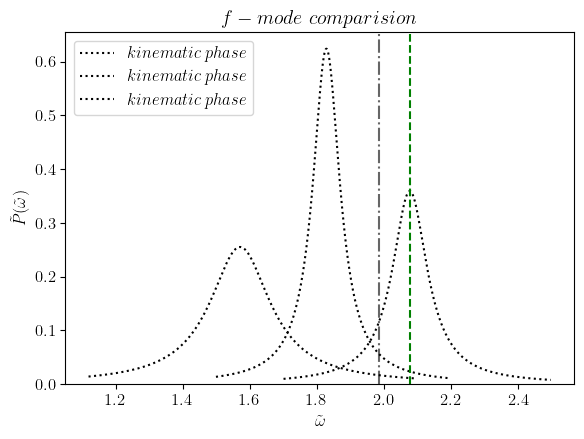

In [ ]:
i = 1
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))

# ax.plot(om_f_kin, f_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.plot(om_f_sat, f_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
# ax.plot(f_sat[i][0], f_sat[i][1], ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
for i in range(3):
    # ax.plot(x_kin[i], y_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
    ax.plot(f_kin[i][0], f_kin[i][1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
ax.axvline(x=f_om[i], ls='-.', c='k', alpha=0.6)
ax.axvline(x=para_f_kin[i][1], ls='--', c='g')
# ax.axvline(x=om_f_kin[indx_peak], ls='--', c='g')
# ax.axvline(x=para_f_sat_lor[1], ls='--', c='g')


plt.ylim(0,)
plt.legend()
plt.xlabel(r"$\tilde{\omega}$")
plt.ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.title(r"$f-mode$ $comparision$")
plt.tight_layout()
plt.show()

## Mode Mass

In [ ]:
def ave(*args):
    list = [*args]
    arr = np.array(list)
    return round(np.sum(arr)/len(list),4)

In [ ]:
# var6 = pc.read.var('VAR6')
# var12 = pc.read.var('VAR12')
# var18 = pc.read.var('VAR18')
# u_d_kin = ave(kinematic.u_rms_d(var6), kinematic.u_rms_d(var12), kinematic.u_rms_d(var18))

In [ ]:
u_d_kin = 0.1246    #NOTE: the value is calculated by above method

In [ ]:
indx = 1
mode_mass_kin = np.zeros(3)
shift_kin = np.zeros(3)
indx_fwhm_kin = np.zeros((3,2))
ln_wd_kin = np.zeros(3)

for indx in range(3):
    mode_mass_kin[indx] = kinematic.mode_mass(f_kin[indx][0], f_kin[indx][1], u_d_kin)#; mode_mass_sat = mode_mass(f_sat[0], f_sat[1], u_d_sat)
    # shift_kin[indx] = kinematic.shift(para_f_kin[indx][1], f_om[indx])
    # indx_fwhm_kin[indx,:] = kinematic.indx_fwhm(f_kin[indx][1], f_kin[indx][0], para_f_kin[indx][1])
    # ln_wd_kin = kinematic.line_width(f_kin[indx][0], indx_fwhm_kin[indx,:], f_om[indx])#; ln_wd_sat =  line_width(f_sat[0], indx_fwhm_sat, f_om)



In [ ]:
np.shape(f_kin)

(3, 2, 1000)

In [ ]:
# f_kin[indx][1]

In [ ]:
indx_fwhm_kin[1,:]

array([0., 0.])

In [ ]:
mode_mass_kin

array([ 9.3965, 10.9599,  8.0146])

In [ ]:
display(Latex(fr'$\mu_{{f,kin}}$ = {mode_mass_kin}'))
# display(Latex(fr'$\mu_{{f,sat}}$ = {mode_mass_sat}'))

<IPython.core.display.Latex object>

In [ ]:
# f_kin

In [ ]:
indx = 0

In [ ]:
shift_kin = kinematic.shift(para_f_kin[indx][1], f_om[indx])
# shift_sat = shift(para_f_sat_lor[1], f_om)

In [ ]:
shift_kin

0.0438

In [ ]:
para_f_kin[indx][1]

1.5712949257831121

In [ ]:
display(Latex(fr'$\delta\omega_{{f,kin}}^2/\omega_f^2$ = {shift_kin}'))
# display(Latex(fr'$\delta\omega_{{f,sat}}^2/\omega_f^2$ = {shift_sat}'))

<IPython.core.display.Latex object>

In [ ]:
indx_fwhm_kin = kinematic.indx_fwhm(f_kin[indx][1], f_kin[indx][0], para_f_kin[indx][1])
# indx_fwhm_sat = indx_fwhm(f_sat[1], f_sat[0], para_f_sat_lor[1])

In [ ]:
indx_fwhm_kin

[349, 572]

In [ ]:
# fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))

# ax.plot(f_kin[i][0], f_kin[i][1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.scatter(f_kin[i][0][indx_fwhm_kin], f_kin[i][1][indx_fwhm_kin])

# # ax.plot(f_sat[0], f_sat[1], ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
# # ax.scatter(f_sat[0][indx_fwhm_sat], f_sat[1][indx_fwhm_sat])

# ax.axvline(x=f_om[i], ls='--', c='k', alpha=0.6)
# ax.axvline(x=para_f_kin[i][1], ls='--', c='g')
# ## ax.axvline(x=om_f_kin[indx_peak], ls='--', c='g')
# # ax.axvline(x=para_f_sat_lor[1], ls='--', c='g')


# plt.ylim(0,)
# plt.legend()
# plt.xlabel(r"$\tilde{\omega}$")
# plt.ylabel(r"$\tilde{P}(\tilde{\omega})$")
# plt.title(r"$f-mode$ $comparision$")
# plt.tight_layout()
# plt.show()

In [ ]:
ln_wd_kin = kinematic.line_width(f_kin[i][0], indx_fwhm_kin, f_om[i])#; ln_wd_sat =  line_width(f_sat[0], indx_fwhm_sat, f_om)


In [ ]:
display(Latex(fr'$\Gamma_{{f,kin}}$ = {ln_wd_kin}'))
# display(Latex(fr'$\Gamma_{{f,sat}}$ = {ln_wd_sat}'))

<IPython.core.display.Latex object>

In [ ]:
# plt.plot(f_om, )